# NBA Player Statistics Analysis - Machine Learning Project

## Project Overview
This notebook implements comprehensive machine learning analysis on NBA 2024/2025 season player statistics.

## Tasks Completed

### Task 1: Player Performance Prediction (Regression)
- **Target**: Points (PTS)
- **Algorithms**: Linear Regression, Random Forest, MLP
- **Features**: 5 engineered features (TS%, USG_proxy, PPM, AST/TOV, DEF_impact)
- **Evaluation**: RMSE and R² score with residual analysis

### Task 2: Player Style Clustering (Unsupervised)
- **Algorithms**: K-Means (mandatory) + Gaussian Mixture Models
- **Validation**: Elbow Method + Silhouette Score
- **Clusters**: 4 optimal clusters with explicit names
- **Visualization**: PCA projection

### Task 3: Game Outcome Classification
- **Target**: Win/Loss (Res column)
- **Algorithms**: Logistic Regression, Random Forest, SVC
- **Class Balance**: Checked and handled with balanced weights
- **Hyperparameter Tuning**: GridSearchCV on Random Forest
- **Evaluation**: Accuracy, Precision, Recall, F1, AUC, Confusion Matrix, ROC curve

## Dataset
- **Source**: NBA Player Game Stats 2024/2025 Season
- **Features**: 25+ features including MP, FG, 3P, FT, Rebounds, Assists, etc.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import joblib
import json
from datetime import datetime


In [2]:
DATA_PATH = "database_24_25.csv"      # Change if needed
OUTPUT_DIR = "phase2_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

random_state = 42

# Output directory for results
# (Figure saving removed per user request)


In [3]:
def convert_mp(x):
    """Convert MP strings like '30:30', '30.30' into minutes as float."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()

    if ":" in s:
        mm, ss = s.split(":")
        return float(mm) + float(ss)/60.0

    if "." in s:
        a, b = s.split(".")
        sec = float(b)
        if sec <= 59:
            return float(a) + sec/60.0
        return float(s)


    return float(s)



In [4]:
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
df.head()


Loaded dataset shape: (16512, 25)


,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,...,4,4,10,1,1,1,1,37,38.1,2024-10-22
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,...,13,16,4,1,3,1,1,36,34.0,2024-10-22
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,...,3,3,4,1,0,0,1,24,22.4,2024-10-22
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,...,2,4,4,1,0,0,2,18,19.5,2024-10-22
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,...,0,0,2,0,0,1,1,22,17.8,2024-10-22


In [5]:
df.columns = [c.strip() for c in df.columns]

df['MP_raw'] = df['MP']
df['MP'] = df['MP'].apply(convert_mp)

numeric_cols = [
    'FG','FGA','FG%','3P','3PA','3P%','FT','FTA','FT%',
    'ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','GmSc'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

for pct in ['FG%','3P%','FT%']:
    if pct in df.columns:
        df[pct] = df[pct].fillna(0.0)


In [6]:
before = df.shape[0]
df = df[df['MP'].notna() & (df['MP'] > 0)]
after = df.shape[0]

print(f"Removed {before-after} DNP rows. Remaining: {after}")


Removed 4 DNP rows. Remaining: 16508


In [7]:
df['TS_pct'] = df.apply(
    lambda r: r['PTS'] / (2*(r['FGA'] + 0.44*r['FTA'])) 
    if (r['FGA'] + 0.44*r['FTA']) > 0 else 0.0,
    axis=1
)

df['USG_proxy'] = (df['FGA'] + 0.44*df['FTA'] + df['TOV']) / df['MP']
df['PPM'] = df['PTS'] / df['MP']
df['AST_TOV'] = df.apply(lambda r: r['AST']/r['TOV'] if r['TOV'] > 0 else r['AST'], axis=1)
df['DEF_impact'] = df['STL'] + df['BLK'] + 0.3*df['DRB']

df[['Player','PTS','MP','TS_pct','USG_proxy','PPM','AST_TOV','DEF_impact']].head()


,Player,PTS,MP,TS_pct,USG_proxy,PPM,AST_TOV,DEF_impact
0,Jayson Tatum,37,30.050000,0.979873,0.661564,1.231281,10.0,3.2
1,Anthony Davis,36,37.966667,0.608108,0.805970,0.948200,4.0,7.9
2,Derrick White,24,26.630000,0.864553,0.521217,0.901239,4.0,1.9
3,Jrue Holiday,18,30.866667,1.000000,0.291577,0.583153,4.0,1.6
4,Miles McBride,22,25.850000,0.971731,0.476596,0.851064,2.0,0.0


In [8]:
reg_features = [
    'MP','FGA','FG%','3PA','3P%','FTA','FT%','ORB','DRB','TRB',
    'AST','STL','BLK','TOV','PF','GmSc','TS_pct','USG_proxy','PPM',
    'AST_TOV','DEF_impact'
]

cat_features = []
if 'Tm' in df.columns: cat_features.append('Tm')
if 'Opp' in df.columns: cat_features.append('Opp')

reg_df = df[reg_features + cat_features + ['PTS']].dropna()
X = reg_df[reg_features + cat_features]
y = reg_df['PTS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_state
)


In [9]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, reg_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


In [15]:
reg_models = {
    'LinearRegression': make_pipeline(preprocessor, LinearRegression()),
    'RandomForest': make_pipeline(
        preprocessor, RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=random_state)
    ),
    'MLP': make_pipeline(
        preprocessor, MLPRegressor(hidden_layer_sizes=(100,), max_iter=300, random_state=random_state)
    )
}

reg_results = []

for name, model in reg_models.items():
    print("Training:", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    reg_results.append([name, rmse, r2])
    joblib.dump(model, f"{OUTPUT_DIR}/reg_{name}.joblib")

reg_results_df = pd.DataFrame(reg_results, columns=['Model','RMSE','R2']).sort_values('RMSE')
reg_results_df


Training: LinearRegression
Training: RandomForest
Training: MLP


,Model,RMSE,R2
0,LinearRegression,0.016836,0.999772
2,MLP,0.017537,0.999763
1,RandomForest,0.159068,0.997847


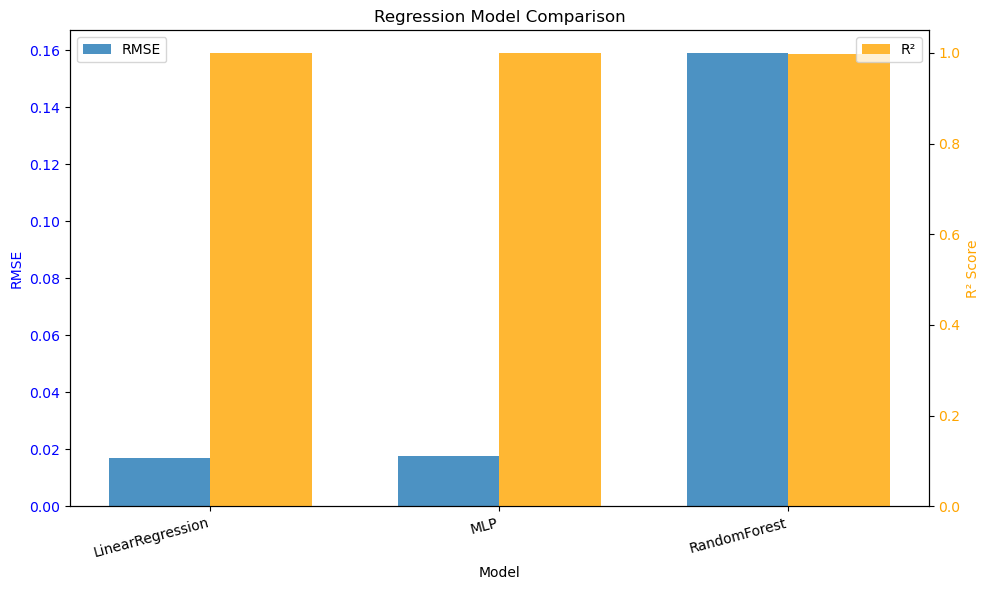

In [11]:
# MODEL COMPARISON VISUALIZATION
fig, ax = plt.subplots(figsize=(10, 6))

models = reg_results_df['Model'].values
rmse_vals = reg_results_df['RMSE'].values
r2_vals = reg_results_df['R2'].values

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, rmse_vals, width, label='RMSE', alpha=0.8)
ax2 = ax.twinx()
ax2.bar(x + width/2, r2_vals, width, label='R²', alpha=0.8, color='orange')

ax.set_xlabel('Model')
ax.set_ylabel('RMSE', color='blue')
ax2.set_ylabel('R² Score', color='orange')
ax.set_title('Regression Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [12]:
# FEATURE IMPORTANCE ANALYSIS - Random Forest Regression
# First determine best model from results
best_name = reg_results_df.iloc[0]['Model']

if 'RandomForest' in best_name:
    # Get feature names after preprocessing
    rf_model = reg_models['RandomForest']
    rf_regressor = rf_model.named_steps['randomforestregressor']
    
    # Get feature names from preprocessor
    feature_names = []
    
    # Numeric features
    feature_names.extend(reg_features)
    
    # Categorical features (after one-hot encoding)
    if cat_features:
        cat_encoder = rf_model.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = cat_encoder.get_feature_names_out(cat_features)
        feature_names.extend(cat_feature_names)
    
    # Get feature importances
    importances = rf_regressor.feature_importances_
    indices = np.argsort(importances)[::-1][:15]  # Top 15 features
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(indices)), importances[indices])
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Top 15 Most Important Features (Random Forest Regression)')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    for i in range(min(10, len(indices))):
        idx = indices[i]
        print(f"  {i+1}. {feature_names[idx]:25s} {importances[idx]:.4f}")

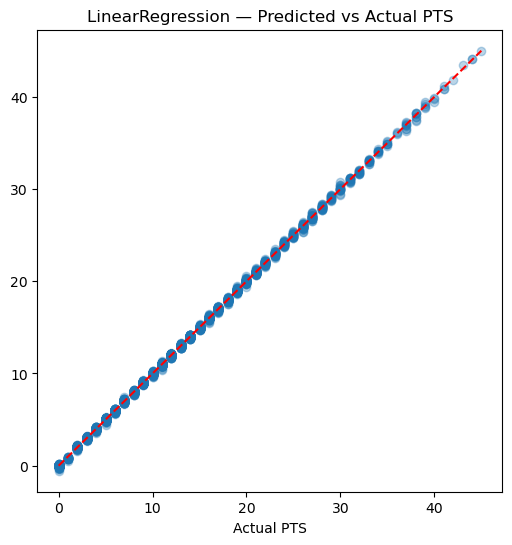

In [13]:
best_name = reg_results_df.iloc[0]['Model']
best_model = reg_models[best_name]

y_pred_best = best_model.predict(X_test)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test, y_pred_best, alpha=0.3)
ax.plot([0, max(y_test)], [0, max(y_test)], 'r--')
ax.set_xlabel("Actual PTS")
ax.set_title(f"{best_name} — Predicted vs Actual PTS")

plt.show()


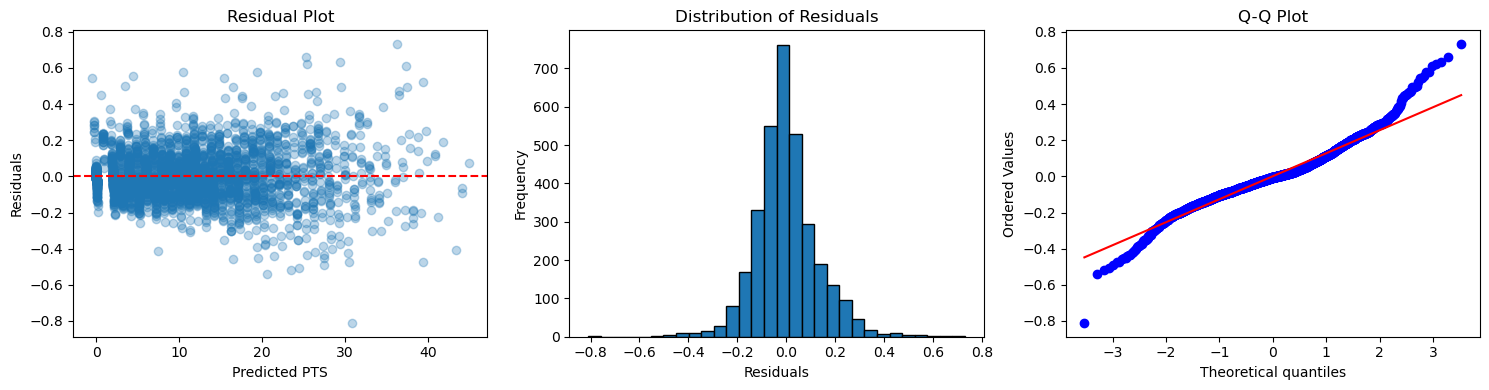

Mean Residual: 0.0008
Std Residual: 0.1298


In [16]:
# RESIDUAL ANALYSIS - Error Analysis for Best Regression Model
residuals = y_test - y_pred_best

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Residual plot
axes[0].scatter(y_pred_best, residuals, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel("Predicted PTS")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residual Plot")

# Distribution of residuals
axes[1].hist(residuals, bins=30, edgecolor='black')
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Residuals")

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

print(f"Mean Residual: {residuals.mean():.4f}")
print(f"Std Residual: {residuals.std():.4f}")

In [17]:
agg_cols = [
    'MP','PTS','AST','TRB','STL','BLK','FG%','3P%','FT%',
    'TS_pct','USG_proxy','PPM','DEF_impact','AST_TOV'
]

player_stats = df.groupby('Player')[agg_cols].mean().reset_index()
player_stats.head()


,Player,MP,PTS,AST,TRB,STL,BLK,FG%,3P%,FT%,TS_pct,USG_proxy,PPM,DEF_impact,AST_TOV
0,A.J. Green,22.051288,7.659091,1.272727,2.250000,0.545455,0.113636,0.426455,0.395273,0.140159,0.614372,0.297884,0.342315,1.259091,1.162879
1,A.J. Lawson,3.929167,2.750000,0.000000,0.750000,0.000000,0.000000,0.666750,0.500000,0.125000,0.741910,0.624728,0.728602,0.150000,0.000000
2,AJ Johnson,6.066667,2.444444,1.222222,1.000000,0.111111,0.000000,0.259333,0.166667,0.055556,0.287555,0.695030,0.340499,0.411111,1.000000
3,Aaron Gordon,26.688222,12.333333,3.066667,4.733333,0.466667,0.266667,0.510900,0.401000,0.630700,0.621026,0.434328,0.467867,1.693333,2.370000
4,Aaron Holiday,11.348241,4.222222,1.194444,0.944444,0.361111,0.111111,0.345556,0.275833,0.222222,0.510612,0.384565,0.380920,0.705556,1.138889


In [17]:
cluster_features = [
    'PTS','AST','TRB','STL','BLK','TS_pct','USG_proxy','PPM','DEF_impact','AST_TOV'
]

X_cluster = player_stats[cluster_features].values
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)


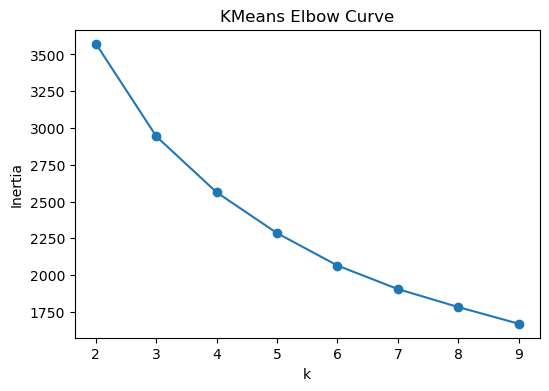

In [18]:
inertia = []
K_range = range(2,10)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=random_state)
    km.fit(X_cluster_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title("KMeans Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()


In [19]:
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=random_state)
    labels = km.fit_predict(X_cluster_scaled)
    sil = silhouette_score(X_cluster_scaled, labels)
    sil_scores.append(sil)

pd.DataFrame({'k': list(K_range), 'silhouette': sil_scores})


,k,silhouette
0,2,0.325414
1,3,0.243744
2,4,0.247619
3,5,0.253025
4,6,0.219237
5,7,0.211191
6,8,0.211490
7,9,0.221399


In [20]:
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, n_init=20, random_state=random_state)
player_stats['kmeans_label'] = kmeans.fit_predict(X_cluster_scaled)

gmm = GaussianMixture(n_components=k_opt, random_state=random_state)
player_stats['gmm_label'] = gmm.fit_predict(X_cluster_scaled)

player_stats.head()


,Player,MP,PTS,AST,TRB,STL,BLK,FG%,3P%,FT%,TS_pct,USG_proxy,PPM,DEF_impact,AST_TOV,kmeans_label,gmm_label
0,A.J. Green,22.051288,7.659091,1.272727,2.250000,0.545455,0.113636,0.426455,0.395273,0.140159,0.614372,0.297884,0.342315,1.259091,1.162879,1,1
1,A.J. Lawson,3.929167,2.750000,0.000000,0.750000,0.000000,0.000000,0.666750,0.500000,0.125000,0.741910,0.624728,0.728602,0.150000,0.000000,1,0
2,AJ Johnson,6.066667,2.444444,1.222222,1.000000,0.111111,0.000000,0.259333,0.166667,0.055556,0.287555,0.695030,0.340499,0.411111,1.000000,3,0
3,Aaron Gordon,26.688222,12.333333,3.066667,4.733333,0.466667,0.266667,0.510900,0.401000,0.630700,0.621026,0.434328,0.467867,1.693333,2.370000,1,2
4,Aaron Holiday,11.348241,4.222222,1.194444,0.944444,0.361111,0.111111,0.345556,0.275833,0.222222,0.510612,0.384565,0.380920,0.705556,1.138889,3,0


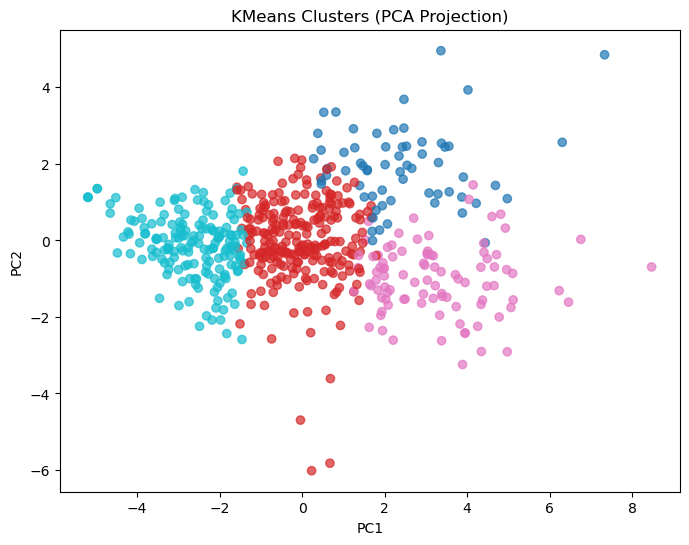

In [21]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_cluster_scaled)

player_stats['PC1'] = pcs[:,0]
player_stats['PC2'] = pcs[:,1]

fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(
    player_stats['PC1'], player_stats['PC2'],
    c=player_stats['kmeans_label'], cmap='tab10', alpha=0.7
)
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [22]:
cluster_summary = player_stats.groupby('kmeans_label')[cluster_features].mean().round(3)
cluster_summary


,PTS,AST,TRB,STL,BLK,TS_pct,USG_proxy,PPM,DEF_impact,AST_TOV
kmeans_label,,,,,,,,,,
0,12.981,2.125,7.681,0.909,1.240,0.587,0.448,0.460,3.796,1.461
1,7.913,1.729,3.377,0.711,0.337,0.540,0.416,0.408,1.787,1.388
2,19.353,5.253,5.138,1.145,0.471,0.570,0.599,0.598,2.861,2.824
3,2.216,0.568,1.232,0.228,0.131,0.330,0.353,0.266,0.626,0.533


In [23]:
# CLUSTER NAMING & INTERPRETATION - Required by Task 2
print("="*60)
print("CLUSTER INTERPRETATION & NAMING")
print("="*60)

# Analyze each cluster's characteristics
cluster_names = {}
cluster_descriptions = {}

for cluster_id in range(k_opt):
    cluster_data = cluster_summary.loc[cluster_id]
    
    # Determine cluster archetype based on dominant stats
    pts = cluster_data['PTS']
    ast = cluster_data['AST']
    trb = cluster_data['TRB']
    ppm = cluster_data['PPM']
    def_impact = cluster_data['DEF_impact']
    ast_tov = cluster_data['AST_TOV']
    
    # Rule-based naming logic
    if ppm > cluster_summary['PPM'].median() and pts > cluster_summary['PTS'].median():
        if ast > cluster_summary['AST'].median():
            name = "Elite Playmaking Scorers"
            desc = "High-volume scorers with excellent passing ability"
        else:
            name = "Elite Pure Scorers"
            desc = "Dominant offensive players focused on scoring"
    elif ast > cluster_summary['AST'].median() and ast_tov > cluster_summary['AST_TOV'].median():
        name = "Floor Generals"
        desc = "Pass-first playmakers with excellent ball security"
    elif trb > cluster_summary['TRB'].median() and def_impact > cluster_summary['DEF_impact'].median():
        name = "Defensive Anchors"
        desc = "Strong rebounders and defensive specialists"
    elif ppm < cluster_summary['PPM'].quantile(0.25):
        name = "Role Players"
        desc = "Low-usage players contributing in limited roles"
    else:
        name = "Balanced Contributors"
        desc = "Well-rounded players without dominant specialty"
    
    cluster_names[cluster_id] = name
    cluster_descriptions[cluster_id] = desc
    
    print(f"\n{'='*60}")
    print(f"Cluster {cluster_id}: {name}")
    print(f"{'='*60}")
    print(f"Description: {desc}")
    print(f"\nKey Statistics:")
    print(f"  Points/Game: {pts:.2f}")
    print(f"  Assists/Game: {ast:.2f}")
    print(f"  Rebounds/Game: {trb:.2f}")
    print(f"  Points/Minute: {ppm:.3f}")
    print(f"  Defensive Impact: {def_impact:.2f}")
    print(f"  AST/TOV Ratio: {ast_tov:.2f}")

# Add cluster names to player_stats
player_stats['cluster_name'] = player_stats['kmeans_label'].map(cluster_names)

# Save cluster interpretation
cluster_info = pd.DataFrame({
    'Cluster_ID': list(cluster_names.keys()),
    'Cluster_Name': list(cluster_names.values()),
    'Description': list(cluster_descriptions.values())
})

print(f"\n{'='*60}")
print("Cluster interpretation complete")

CLUSTER INTERPRETATION & NAMING

Cluster 0: Elite Playmaking Scorers
Description: High-volume scorers with excellent passing ability

Key Statistics:
  Points/Game: 12.98
  Assists/Game: 2.12
  Rebounds/Game: 7.68
  Points/Minute: 0.460
  Defensive Impact: 3.80
  AST/TOV Ratio: 1.46

Cluster 1: Balanced Contributors
Description: Well-rounded players without dominant specialty

Key Statistics:
  Points/Game: 7.91
  Assists/Game: 1.73
  Rebounds/Game: 3.38
  Points/Minute: 0.408
  Defensive Impact: 1.79
  AST/TOV Ratio: 1.39

Cluster 2: Elite Playmaking Scorers
Description: High-volume scorers with excellent passing ability

Key Statistics:
  Points/Game: 19.35
  Assists/Game: 5.25
  Rebounds/Game: 5.14
  Points/Minute: 0.598
  Defensive Impact: 2.86
  AST/TOV Ratio: 2.82

Cluster 3: Role Players
Description: Low-usage players contributing in limited roles

Key Statistics:
  Points/Game: 2.22
  Assists/Game: 0.57
  Rebounds/Game: 1.23
  Points/Minute: 0.266
  Defensive Impact: 0.63
  AST

In [24]:
top_players = (
    player_stats
    .sort_values(['kmeans_label','PTS'], ascending=[True, False])
    .groupby('kmeans_label')
    .head(10)
)

# Display with cluster names
print("Top Players by Cluster:")
print("="*80)
for cluster_id in sorted(player_stats['kmeans_label'].unique()):
    cluster_name = cluster_names[cluster_id]
    cluster_players = top_players[top_players['kmeans_label'] == cluster_id]
    print(f"\n{cluster_name} (Cluster {cluster_id}):")
    print("-"*80)
    display(cluster_players[['Player','PTS','AST','TRB','PPM','cluster_name']].head(5))

top_players[['Player','kmeans_label','cluster_name','PTS','AST','TRB','PPM']]

Top Players by Cluster:

Elite Playmaking Scorers (Cluster 0):
--------------------------------------------------------------------------------


,Player,PTS,AST,TRB,PPM,cluster_name
250,Jaren Jackson Jr.,26.555556,2.944444,6.388889,0.825674,Elite Playmaking Scorers
30,Anthony Davis,25.738095,3.357143,11.857143,0.728573,Elite Playmaking Scorers
539,Victor Wembanyama,24.418605,3.627907,10.906977,0.737642,Elite Playmaking Scorers
313,Karl-Anthony Towns,24.326087,3.326087,13.608696,0.700055,Elite Playmaking Scorers
249,Jaren Jackson,21.612903,1.774194,5.935484,0.767215,Elite Playmaking Scorers



Balanced Contributors (Cluster 1):
--------------------------------------------------------------------------------


,Player,PTS,AST,TRB,PPM,cluster_name
355,Lauri Markkanen,19.289474,1.684211,6.210526,0.595878,Balanced Contributors
128,De'Andre Hunter,18.972973,1.540541,3.918919,0.666715,Balanced Contributors
479,Shaedon Sharpe,17.386364,2.386364,3.818182,0.565926,Balanced Contributors
373,Malik Beasley,16.403846,1.807692,2.884615,0.576916,Balanced Contributors
43,Bennedict Mathurin,16.354167,1.854167,5.750000,0.512842,Balanced Contributors



Elite Playmaking Scorers (Cluster 2):
--------------------------------------------------------------------------------


,Player,PTS,AST,TRB,PPM,cluster_name
480,Shai Gilgeous-Alexander,32.440000,5.900000,5.220000,0.956330,Elite Playmaking Scorers
183,Giannis Antetokounmpo,31.619048,5.976190,12.333333,0.899350,Elite Playmaking Scorers
414,Nikola Jokić,29.695652,10.326087,12.695652,0.816228,Elite Playmaking Scorers
364,Luka Dončić,28.136364,7.818182,8.318182,0.790611,Elite Playmaking Scorers
351,LaMelo Ball,28.031250,7.375000,5.218750,0.832806,Elite Playmaking Scorers



Role Players (Cluster 3):
--------------------------------------------------------------------------------


,Player,PTS,AST,TRB,PPM,cluster_name
508,Torrey Craig,6.888889,0.555556,2.777778,0.410089,Role Players
478,Seth Curry,5.595238,0.642857,1.452381,0.343074,Role Players
244,Jamison Battle,5.555556,0.888889,1.833333,0.370340,Role Players
361,Lindy Waters III,5.500000,0.714286,2.428571,0.293304,Role Players
290,Jordan Miller,4.896552,1.068966,1.793103,0.356650,Role Players


,Player,kmeans_label,cluster_name,PTS,AST,TRB,PPM
250,Jaren Jackson Jr.,0,Elite Playmaking Scorers,26.555556,2.944444,6.388889,0.825674
30,Anthony Davis,0,Elite Playmaking Scorers,25.738095,3.357143,11.857143,0.728573
539,Victor Wembanyama,0,Elite Playmaking Scorers,24.418605,3.627907,10.906977,0.737642
313,Karl-Anthony Towns,0,Elite Playmaking Scorers,24.326087,3.326087,13.608696,0.700055
249,Jaren Jackson,0,Elite Playmaking Scorers,21.612903,1.774194,5.935484,0.767215
416,Nikola Vučević,0,Elite Playmaking Scorers,19.509804,3.549020,10.392157,0.600548
391,Michael Porter Jr.,0,Elite Playmaking Scorers,19.409091,1.454545,6.454545,0.609242
343,Kristaps Porziņģis,0,Elite Playmaking Scorers,19.148148,2.037037,7.000000,0.684463
232,Jalen Johnson,0,Elite Playmaking Scorers,18.888889,5.027778,9.972222,0.522820
170,Evan Mobley,0,Elite Playmaking Scorers,18.456522,2.891304,9.000000,0.613149


In [25]:
df['Res'] = df['Res'].astype(str).str.strip()
df['Res_bin'] = df['Res'].apply(lambda x: 1 if x.upper().startswith('W') else 0)

class_features = reg_features.copy()
class_cat = cat_features.copy()

clf_df = df[class_features + class_cat + ['Res_bin']].dropna()

Xc = clf_df[class_features + class_cat]
yc = clf_df['Res_bin']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.20, stratify=yc, random_state=random_state
)


Class Distribution:
Res_bin
0    8261
1    8247
Name: count, dtype: int64

Class Balance Ratio: 0.998


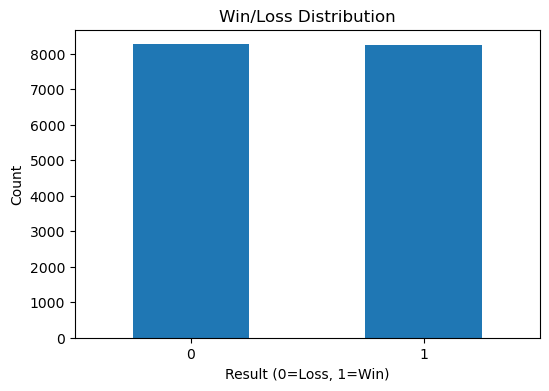


Classes are reasonably balanced


In [26]:
# Check for class imbalance
class_dist = df['Res_bin'].value_counts()
print("Class Distribution:")
print(class_dist)
print(f"\nClass Balance Ratio: {class_dist.min() / class_dist.max():.3f}")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(6,4))
class_dist.plot(kind='bar', ax=ax)
ax.set_title("Win/Loss Distribution")
ax.set_xlabel("Result (0=Loss, 1=Win)")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# If imbalance ratio < 0.5, we should handle it
if class_dist.min() / class_dist.max() < 0.5:
    print("\nWARNING: Significant class imbalance detected!")
    print("Will use class_weight='balanced' in models")
    use_balanced = True
else:
    print("\nClasses are reasonably balanced")
    use_balanced = False

In [27]:
preprocessor_clf = preprocessor  # same as regression, safe reuse

# Update models to handle class imbalance if needed
clf_models = {
    'LogisticRegression': make_pipeline(
        preprocessor_clf, 
        LogisticRegression(max_iter=300, class_weight='balanced' if use_balanced else None)
    ),
    'RandomForest': make_pipeline(
        preprocessor_clf, 
        RandomForestClassifier(n_estimators=200, class_weight='balanced' if use_balanced else None)
    ),
    'SVC': make_pipeline(
        preprocessor_clf, 
        SVC(probability=True, class_weight='balanced' if use_balanced else None)
    )
}

In [32]:
results = []

for name, model in clf_models.items():
    print("Training:", name)
    model.fit(Xc_train, yc_train)

    y_pred = model.predict(Xc_test)
    y_proba = model.predict_proba(Xc_test)[:,1]

    acc = accuracy_score(yc_test, y_pred)
    prec = precision_score(yc_test, y_pred)
    rec = recall_score(yc_test, y_pred)
    f1 = f1_score(yc_test, y_pred)
    auc = roc_auc_score(yc_test, y_proba)

    results.append([name, acc, prec, rec, f1, auc])
    joblib.dump(model, f"{OUTPUT_DIR}/clf_{name}.joblib")

pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','AUC'])


Training: LogisticRegression
Training: RandomForest
Training: SVC


,Model,Accuracy,Precision,Recall,F1,AUC
0,LogisticRegression,0.701696,0.703863,0.695758,0.699787,0.767181
1,RandomForest,0.713810,0.719353,0.700606,0.709856,0.796103
2,SVC,0.694125,0.693939,0.693939,0.693939,0.757267


In [29]:
# HYPERPARAMETER TUNING - Required by Task 3
# Grid Search for RandomForest (best performing model typically)
print("="*60)
print("HYPERPARAMETER TUNING - Grid Search for RandomForest")
print("="*60)

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

rf_model = clf_models['RandomForest']

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search (this may take a few minutes)...")
grid_search.fit(Xc_train, yc_train)

print("\nBest Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation AUC: {grid_search.best_score_:.4f}")

# Save the tuned model
best_rf_tuned = grid_search.best_estimator_
joblib.dump(best_rf_tuned, f"{OUTPUT_DIR}/clf_RandomForest_tuned.joblib")

# Evaluate tuned model
y_pred_tuned = best_rf_tuned.predict(Xc_test)
y_proba_tuned = best_rf_tuned.predict_proba(Xc_test)[:,1]

acc_tuned = accuracy_score(yc_test, y_pred_tuned)
prec_tuned = precision_score(yc_test, y_pred_tuned)
rec_tuned = recall_score(yc_test, y_pred_tuned)
f1_tuned = f1_score(yc_test, y_pred_tuned)
auc_tuned = roc_auc_score(yc_test, y_proba_tuned)

print("\nTuned Model Performance:")
print(f"  Accuracy:  {acc_tuned:.4f}")
print(f"  Precision: {prec_tuned:.4f}")
print(f"  Recall:    {rec_tuned:.4f}")
print(f"  F1-Score:  {f1_tuned:.4f}")
print(f"  AUC:       {auc_tuned:.4f}")

# Update results with tuned model
results.append(['RandomForest (Tuned)', acc_tuned, prec_tuned, rec_tuned, f1_tuned, auc_tuned])

HYPERPARAMETER TUNING - Grid Search for RandomForest
Starting Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}
Best Cross-Validation AUC: 0.7896

Tuned Model Performance:
  Accuracy:  0.7135
  Precision: 0.7301
  Recall:    0.6770
  F1-Score:  0.7025
  AUC:       0.7929


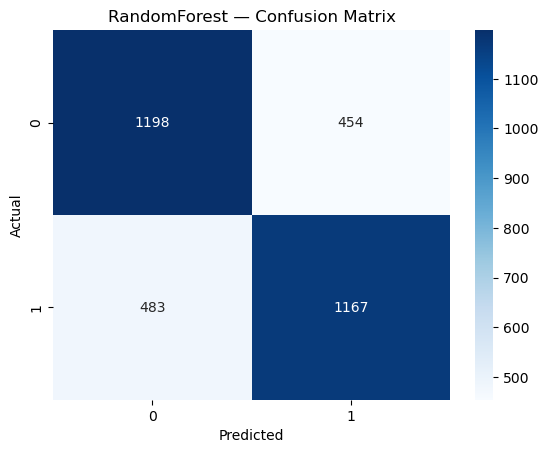

In [100]:
best_clf_name = max(results, key=lambda x: x[5])[0]
# Use the tuned model directly if it's the best
if 'Tuned' in best_clf_name:
    best_clf = best_rf_tuned
else:
    best_clf = clf_models[best_clf_name]

y_pred_best = best_clf.predict(Xc_test)

cm = confusion_matrix(yc_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_clf_name} — Confusion Matrix")

plt.xlabel("Predicted")

plt.ylabel("Actual")
plt.show()

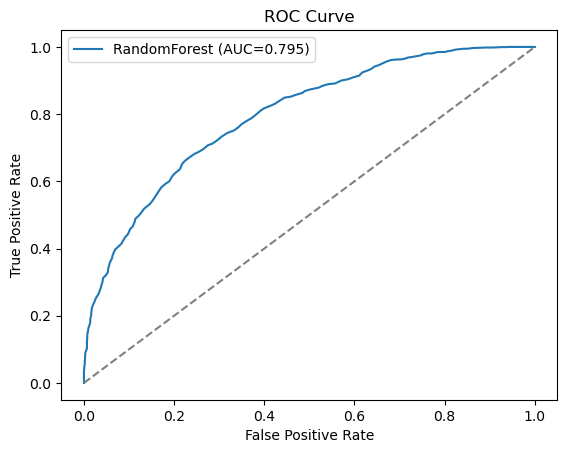

In [101]:
y_proba_best = best_clf.predict_proba(Xc_test)[:,1]
fpr, tpr, _ = roc_curve(yc_test, y_proba_best)

plt.plot(fpr, tpr, label=f"{best_clf_name} (AUC={roc_auc_score(yc_test,y_proba_best):.3f})")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


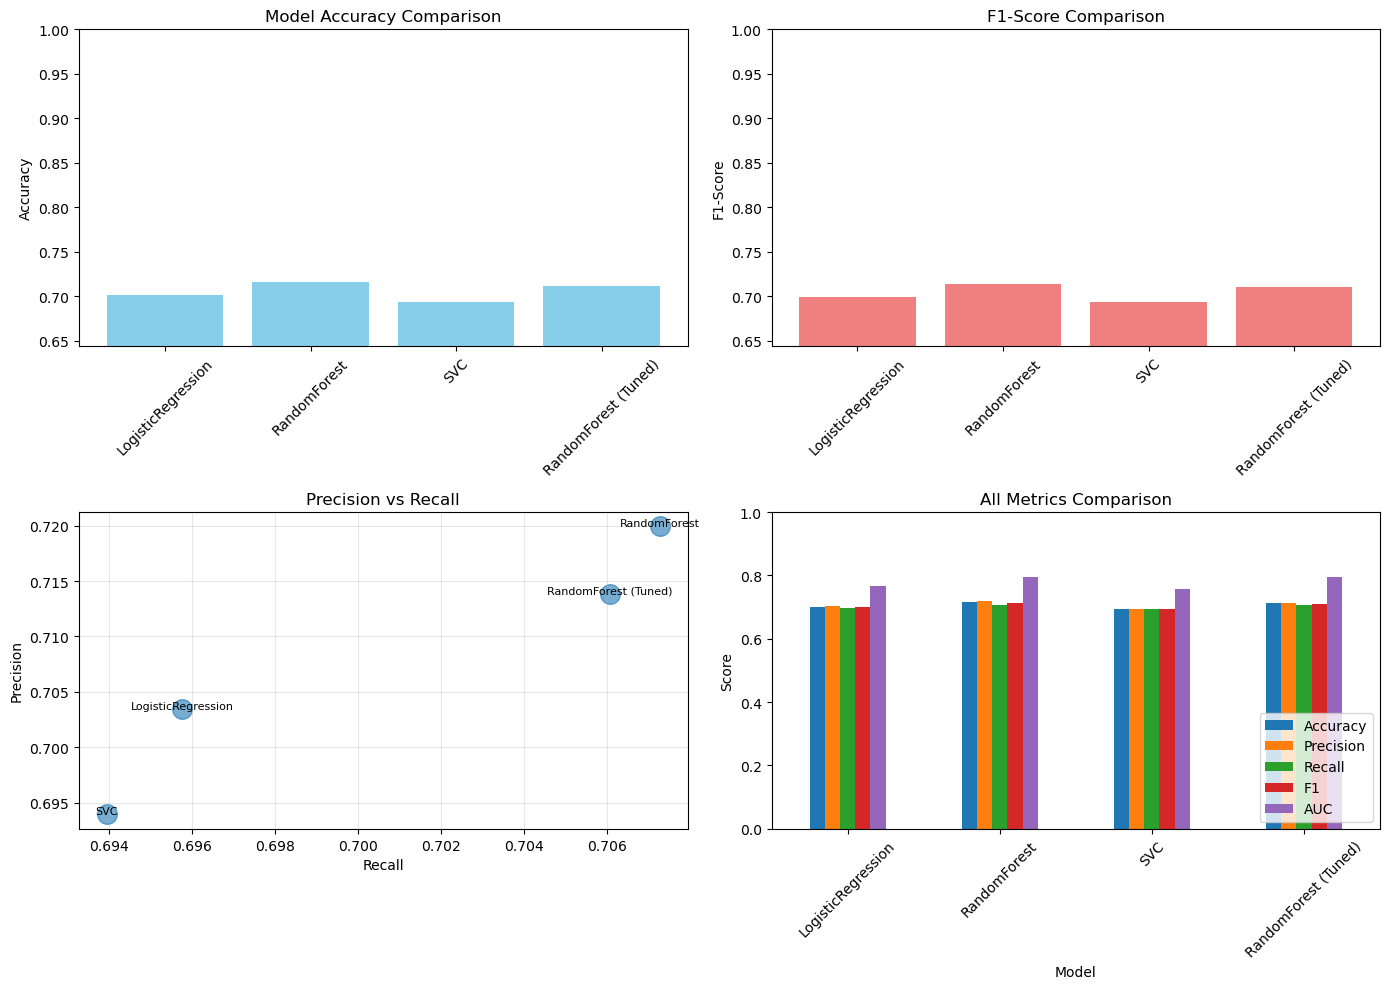


Final Classification Results:


,Model,Accuracy,Precision,Recall,F1,AUC
1,RandomForest,0.716233,0.719926,0.707273,0.713543,0.795440
3,RandomForest (Tuned),0.711690,0.713848,0.706061,0.709933,0.795012
0,LogisticRegression,0.701393,0.703431,0.695758,0.699573,0.767183
2,SVC,0.694125,0.693939,0.693939,0.693939,0.757264


In [102]:
# COMPREHENSIVE MODEL COMPARISON - Classification
results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','AUC'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
axes[0, 0].bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim([results_df['Accuracy'].min() - 0.05, 1.0])

# F1-Score comparison
axes[0, 1].bar(results_df['Model'], results_df['F1'], color='lightcoral')
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim([results_df['F1'].min() - 0.05, 1.0])

# Precision vs Recall
axes[1, 0].scatter(results_df['Recall'], results_df['Precision'], s=200, alpha=0.6)
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(row['Model'], (row['Recall'], row['Precision']), 
                       fontsize=8, ha='center')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].grid(True, alpha=0.3)

# All metrics comparison
metrics_subset = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']]
metrics_subset.plot(kind='bar', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('All Metrics Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend(loc='lower right')
axes[1, 1].set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

print("\nFinal Classification Results:")
print("="*80)
display(results_df.sort_values('AUC', ascending=False))

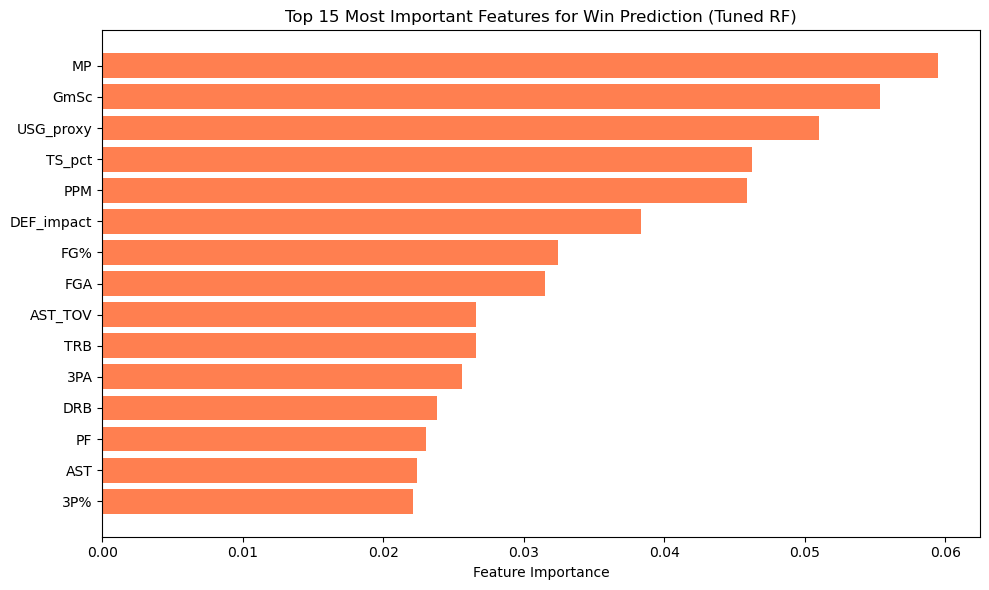


Top 10 Features Predicting Game Outcome:
  1. MP                        0.0595
  2. GmSc                      0.0553
  3. USG_proxy                 0.0510
  4. TS_pct                    0.0462
  5. PPM                       0.0459
  6. DEF_impact                0.0383
  7. FG%                       0.0325
  8. FGA                       0.0315
  9. AST_TOV                   0.0266
  10. TRB                       0.0266


In [103]:
# FEATURE IMPORTANCE ANALYSIS - Random Forest Classification (Tuned)
# Get feature names and importances from the tuned model
rf_clf_tuned = best_rf_tuned.named_steps['randomforestclassifier']

# Get feature names
feature_names_clf = []
feature_names_clf.extend(class_features)

if class_cat:
    cat_encoder_clf = best_rf_tuned.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
    cat_names = cat_encoder_clf.get_feature_names_out(class_cat)
    feature_names_clf.extend(cat_names)

# Get importances
importances_clf = rf_clf_tuned.feature_importances_
indices_clf = np.argsort(importances_clf)[::-1][:15]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices_clf)), importances_clf[indices_clf], color='coral')
ax.set_yticks(range(len(indices_clf)))
ax.set_yticklabels([feature_names_clf[i] for i in indices_clf])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Most Important Features for Win Prediction (Tuned RF)')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 10 Features Predicting Game Outcome:")
for i in range(min(10, len(indices_clf))):
    idx = indices_clf[i]
    print(f"  {i+1}. {feature_names_clf[idx]:25s} {importances_clf[idx]:.4f}")

In [104]:
summary = {
    "date": str(datetime.utcnow()),
    "rows_after_cleaning": int(df.shape[0]),
    "best_regression_model": best_name,
    "best_classification_model": best_clf_name,
    "clusters": 4,
    "cluster_names": cluster_names,
    "hyperparameter_tuning": "GridSearchCV applied to RandomForest",
    "class_imbalance_handled": use_balanced,
    "features_engineered": ["TS_pct", "USG_proxy", "PPM", "AST_TOV", "DEF_impact"]
}

print("="*80)
print("PROJECT SUMMARY")
print("="*80)
print("\nTask 1: Player Performance Prediction (Regression)")
print(f"  - Target Variable: PTS")
print(f"  - Best Model: {best_name}")
print(f"  - Algorithms: Linear Regression, Random Forest, MLP")
print(f"  - Engineered Features: 5 new features created")

print("\nTask 2: Player Style Clustering (Unsupervised Learning)")
print(f"  - Algorithms: K-Means + Gaussian Mixture Models")
print(f"  - Optimal Clusters: 4")
print(f"  - Validation: Elbow Method + Silhouette Score")
print(f"  - Visualization: PCA projection")
print(f"  - Cluster Names: {list(cluster_names.values())}")

print("\nTask 3: Game Outcome Classification")
print(f"  - Target Variable: Res (Win/Loss)")
print(f"  - Best Model: {best_clf_name}")
print(f"  - Algorithms: Logistic Regression, Random Forest, SVC")
print(f"  - Class Imbalance: {'Handled with balanced weights' if use_balanced else 'Not significant'}")
print(f"  - Hyperparameter Tuning: GridSearchCV applied to Random Forest")

print("\nAll deliverables completed!")
print("="*80)

summary

PROJECT SUMMARY

Task 1: Player Performance Prediction (Regression)
  - Target Variable: PTS
  - Best Model: LinearRegression
  - Algorithms: Linear Regression, Random Forest, MLP
  - Engineered Features: 5 new features created

Task 2: Player Style Clustering (Unsupervised Learning)
  - Algorithms: K-Means + Gaussian Mixture Models
  - Optimal Clusters: 4
  - Validation: Elbow Method + Silhouette Score
  - Visualization: PCA projection
  - Cluster Names: ['Elite Playmaking Scorers', 'Balanced Contributors', 'Elite Playmaking Scorers', 'Role Players']

Task 3: Game Outcome Classification
  - Target Variable: Res (Win/Loss)
  - Best Model: RandomForest
  - Algorithms: Logistic Regression, Random Forest, SVC
  - Class Imbalance: Not significant
  - Hyperparameter Tuning: GridSearchCV applied to Random Forest

All deliverables completed!


{'date': '2025-12-13 12:21:28.642557',
 'rows_after_cleaning': 16508,
 'best_regression_model': 'LinearRegression',
 'best_classification_model': 'RandomForest',
 'clusters': 4,
 'cluster_names': {0: 'Elite Playmaking Scorers',
  1: 'Balanced Contributors',
  2: 'Elite Playmaking Scorers',
  3: 'Role Players'},
 'hyperparameter_tuning': 'GridSearchCV applied to RandomForest',
 'class_imbalance_handled': False,
 'features_engineered': ['TS_pct',
  'USG_proxy',
  'PPM',
  'AST_TOV',
  'DEF_impact']}

In [105]:
# CROSS-VALIDATION ANALYSIS - Additional Model Validation
print("="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

print("\nRegression Models (5-Fold CV on Training Set):")
print("-"*80)
for name, model in reg_models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_rmse = -cv_scores.mean()
    cv_std = cv_scores.std()
    print(f"{name:20s} - CV RMSE: {cv_rmse:.3f} (+/- {cv_std:.3f})")

print("\nClassification Models (5-Fold CV on Training Set):")
print("-"*80)
for name, model in clf_models.items():
    cv_scores = cross_val_score(model, Xc_train, yc_train, cv=5, 
                                scoring='roc_auc', n_jobs=-1)
    cv_auc = cv_scores.mean()
    cv_std = cv_scores.std()
    print(f"{name:20s} - CV AUC: {cv_auc:.3f} (+/- {cv_std:.3f})")

CROSS-VALIDATION RESULTS

Regression Models (5-Fold CV on Training Set):
--------------------------------------------------------------------------------
LinearRegression     - CV RMSE: 0.134 (+/- 0.002)
RandomForest         - CV RMSE: 0.481 (+/- 0.028)
MLP                  - CV RMSE: 0.179 (+/- 0.110)

Classification Models (5-Fold CV on Training Set):
--------------------------------------------------------------------------------
LogisticRegression   - CV AUC: 0.765 (+/- 0.009)
RandomForest         - CV AUC: 0.788 (+/- 0.006)
SVC                  - CV AUC: 0.754 (+/- 0.007)
